In [2]:
import pandas as pd
import numpy as np

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split , cross_validate, cross_val_score, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


import catboost as cb
from sklearn.metrics import *

In [3]:
df=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
sample_submission=pd.read_csv('sample_submission.csv')

In [4]:
sample_submission.head()  # Пример ответа 

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [5]:
print(f'train:{df.shape}')
print(f'test:{test.shape}')

train:(1460, 81)
test:(1459, 80)


In [6]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
df = df.drop("Id" ,axis=1)

In [8]:
def missing_values(df): 
    current=0
    for i in df.columns:
        if pd.isnull(df[i]).any():
            current =1
            print(f"В столбце {i}, есть пропущенные значения.{pd.isnull(df[i]).any()}")
    if not current:
        print("Пропущенных значений нет")

In [9]:
def transformation_cols(df):
    missing_values(df)
    for i in list(df.select_dtypes(include='object').columns):
        df[i] = df[i].fillna('nan')
        df[i] = df[i].astype(str)
    print("\nВ 'object' все пропущенные значения обработаны")
    for i in list(df.select_dtypes(include='int').columns):
        if i not in  'Id':
            df[i] = df[i].fillna(0)
            df[i] = df[i].astype(float)
    print("В 'int' все пропущенные значения обработаны")
    for i in list(df.select_dtypes(include='float').columns):
        if i not in  'Id':
            df[i] = df[i].fillna(0)
            df[i] = df[i].astype(float)
    print("В 'float' все пропущенные значения обработаны")

In [10]:
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [11]:
transformation_cols(df)

В столбце LotFrontage, есть пропущенные значения.True
В столбце Alley, есть пропущенные значения.True
В столбце MasVnrType, есть пропущенные значения.True
В столбце MasVnrArea, есть пропущенные значения.True
В столбце BsmtQual, есть пропущенные значения.True
В столбце BsmtCond, есть пропущенные значения.True
В столбце BsmtExposure, есть пропущенные значения.True
В столбце BsmtFinType1, есть пропущенные значения.True
В столбце BsmtFinType2, есть пропущенные значения.True
В столбце Electrical, есть пропущенные значения.True
В столбце FireplaceQu, есть пропущенные значения.True
В столбце GarageType, есть пропущенные значения.True
В столбце GarageYrBlt, есть пропущенные значения.True
В столбце GarageFinish, есть пропущенные значения.True
В столбце GarageQual, есть пропущенные значения.True
В столбце GarageCond, есть пропущенные значения.True
В столбце PoolQC, есть пропущенные значения.True
В столбце Fence, есть пропущенные значения.True
В столбце MiscFeature, есть пропущенные значения.True

In [12]:
transformation_cols(test)

В столбце MSZoning, есть пропущенные значения.True
В столбце LotFrontage, есть пропущенные значения.True
В столбце Alley, есть пропущенные значения.True
В столбце Utilities, есть пропущенные значения.True
В столбце Exterior1st, есть пропущенные значения.True
В столбце Exterior2nd, есть пропущенные значения.True
В столбце MasVnrType, есть пропущенные значения.True
В столбце MasVnrArea, есть пропущенные значения.True
В столбце BsmtQual, есть пропущенные значения.True
В столбце BsmtCond, есть пропущенные значения.True
В столбце BsmtExposure, есть пропущенные значения.True
В столбце BsmtFinType1, есть пропущенные значения.True
В столбце BsmtFinSF1, есть пропущенные значения.True
В столбце BsmtFinType2, есть пропущенные значения.True
В столбце BsmtFinSF2, есть пропущенные значения.True
В столбце BsmtUnfSF, есть пропущенные значения.True
В столбце TotalBsmtSF, есть пропущенные значения.True
В столбце BsmtFullBath, есть пропущенные значения.True
В столбце BsmtHalfBath, есть пропущенные значен

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   float64
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   float64
 4   Street         1460 non-null   object 
 5   Alley          1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   float64
 17  OverallCond    1460 non-null   float64
 18  YearBuil

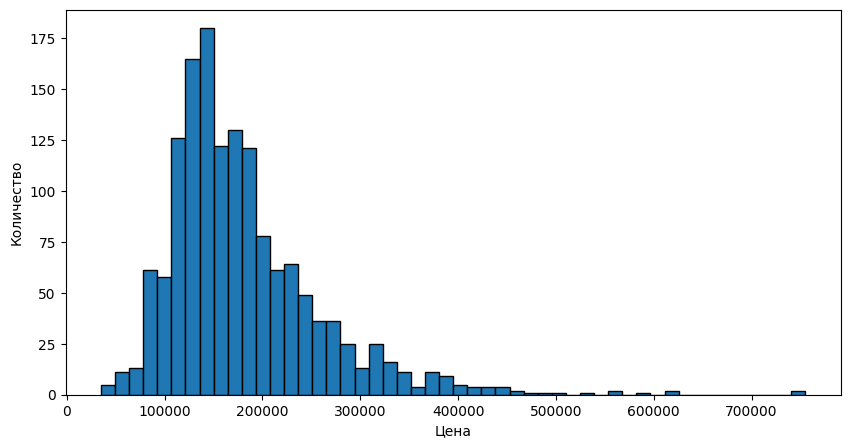

In [14]:
plt.figure(figsize=(10,5))
plt.hist(df['SalePrice'],bins=50,ec='black')
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.show()


In [15]:
cat_cols = [i for i in list(df.select_dtypes(include='object').columns)]
num_cols = [i for i in list(df.select_dtypes(include='float64').columns)][0:-1]

In [16]:
features = cat_cols+num_cols
target = 'SalePrice'

In [17]:
df[features]

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,RL,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0
1,RL,Pave,nan,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0
2,RL,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0
3,RL,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0
4,RL,Pave,nan,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,460.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,8.0,2007.0
1456,RL,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,500.0,349.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2010.0
1457,RL,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,252.0,0.0,60.0,0.0,0.0,0.0,0.0,2500.0,5.0,2010.0
1458,RL,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,240.0,366.0,0.0,112.0,0.0,0.0,0.0,0.0,4.0,2010.0


In [18]:
df.select_dtypes(include='object')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,nan,nan,nan,WD,Normal
1,RL,Pave,nan,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,nan,nan,nan,WD,Normal
2,RL,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,nan,nan,nan,WD,Normal
3,RL,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,nan,nan,nan,WD,Abnorml
4,RL,Pave,nan,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,nan,nan,nan,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,nan,nan,nan,WD,Normal
1456,RL,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,nan,MnPrv,nan,WD,Normal
1457,RL,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,nan,GdPrv,Shed,WD,Normal
1458,RL,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,nan,nan,nan,WD,Normal


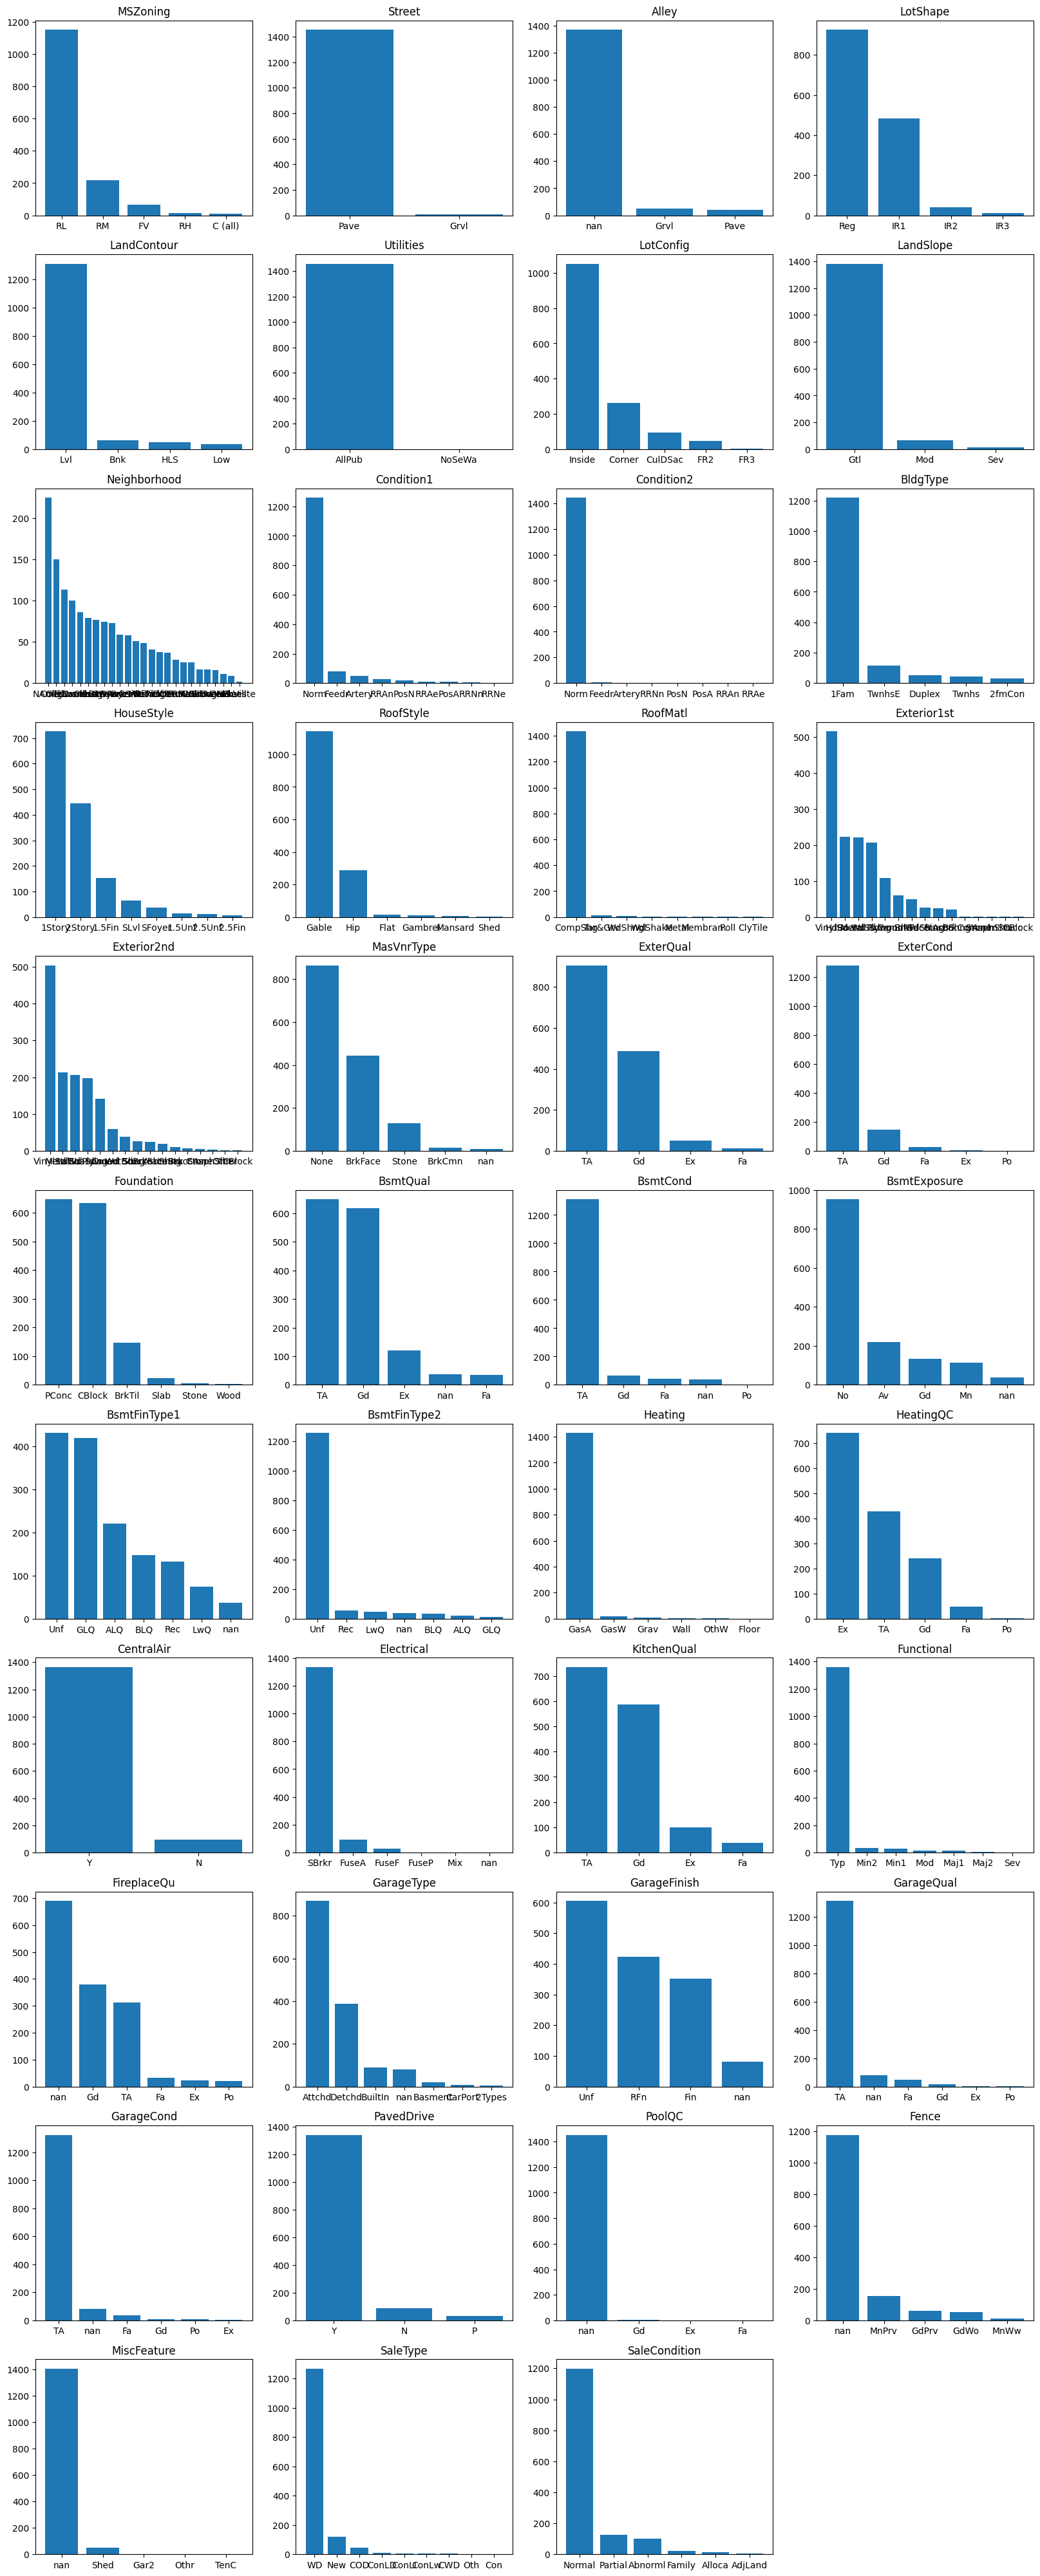

In [19]:
d = [df[i].value_counts() for i in list(df[cat_cols].columns)]
plt.figure(figsize=(20,70))
for i,j in enumerate(df[cat_cols]):
    ax = plt.subplot(15,4, i + 1)
    ax.set_title(j)
    b = plt.bar(d[i].keys(), d[i].values)
    figsize=(15,15)

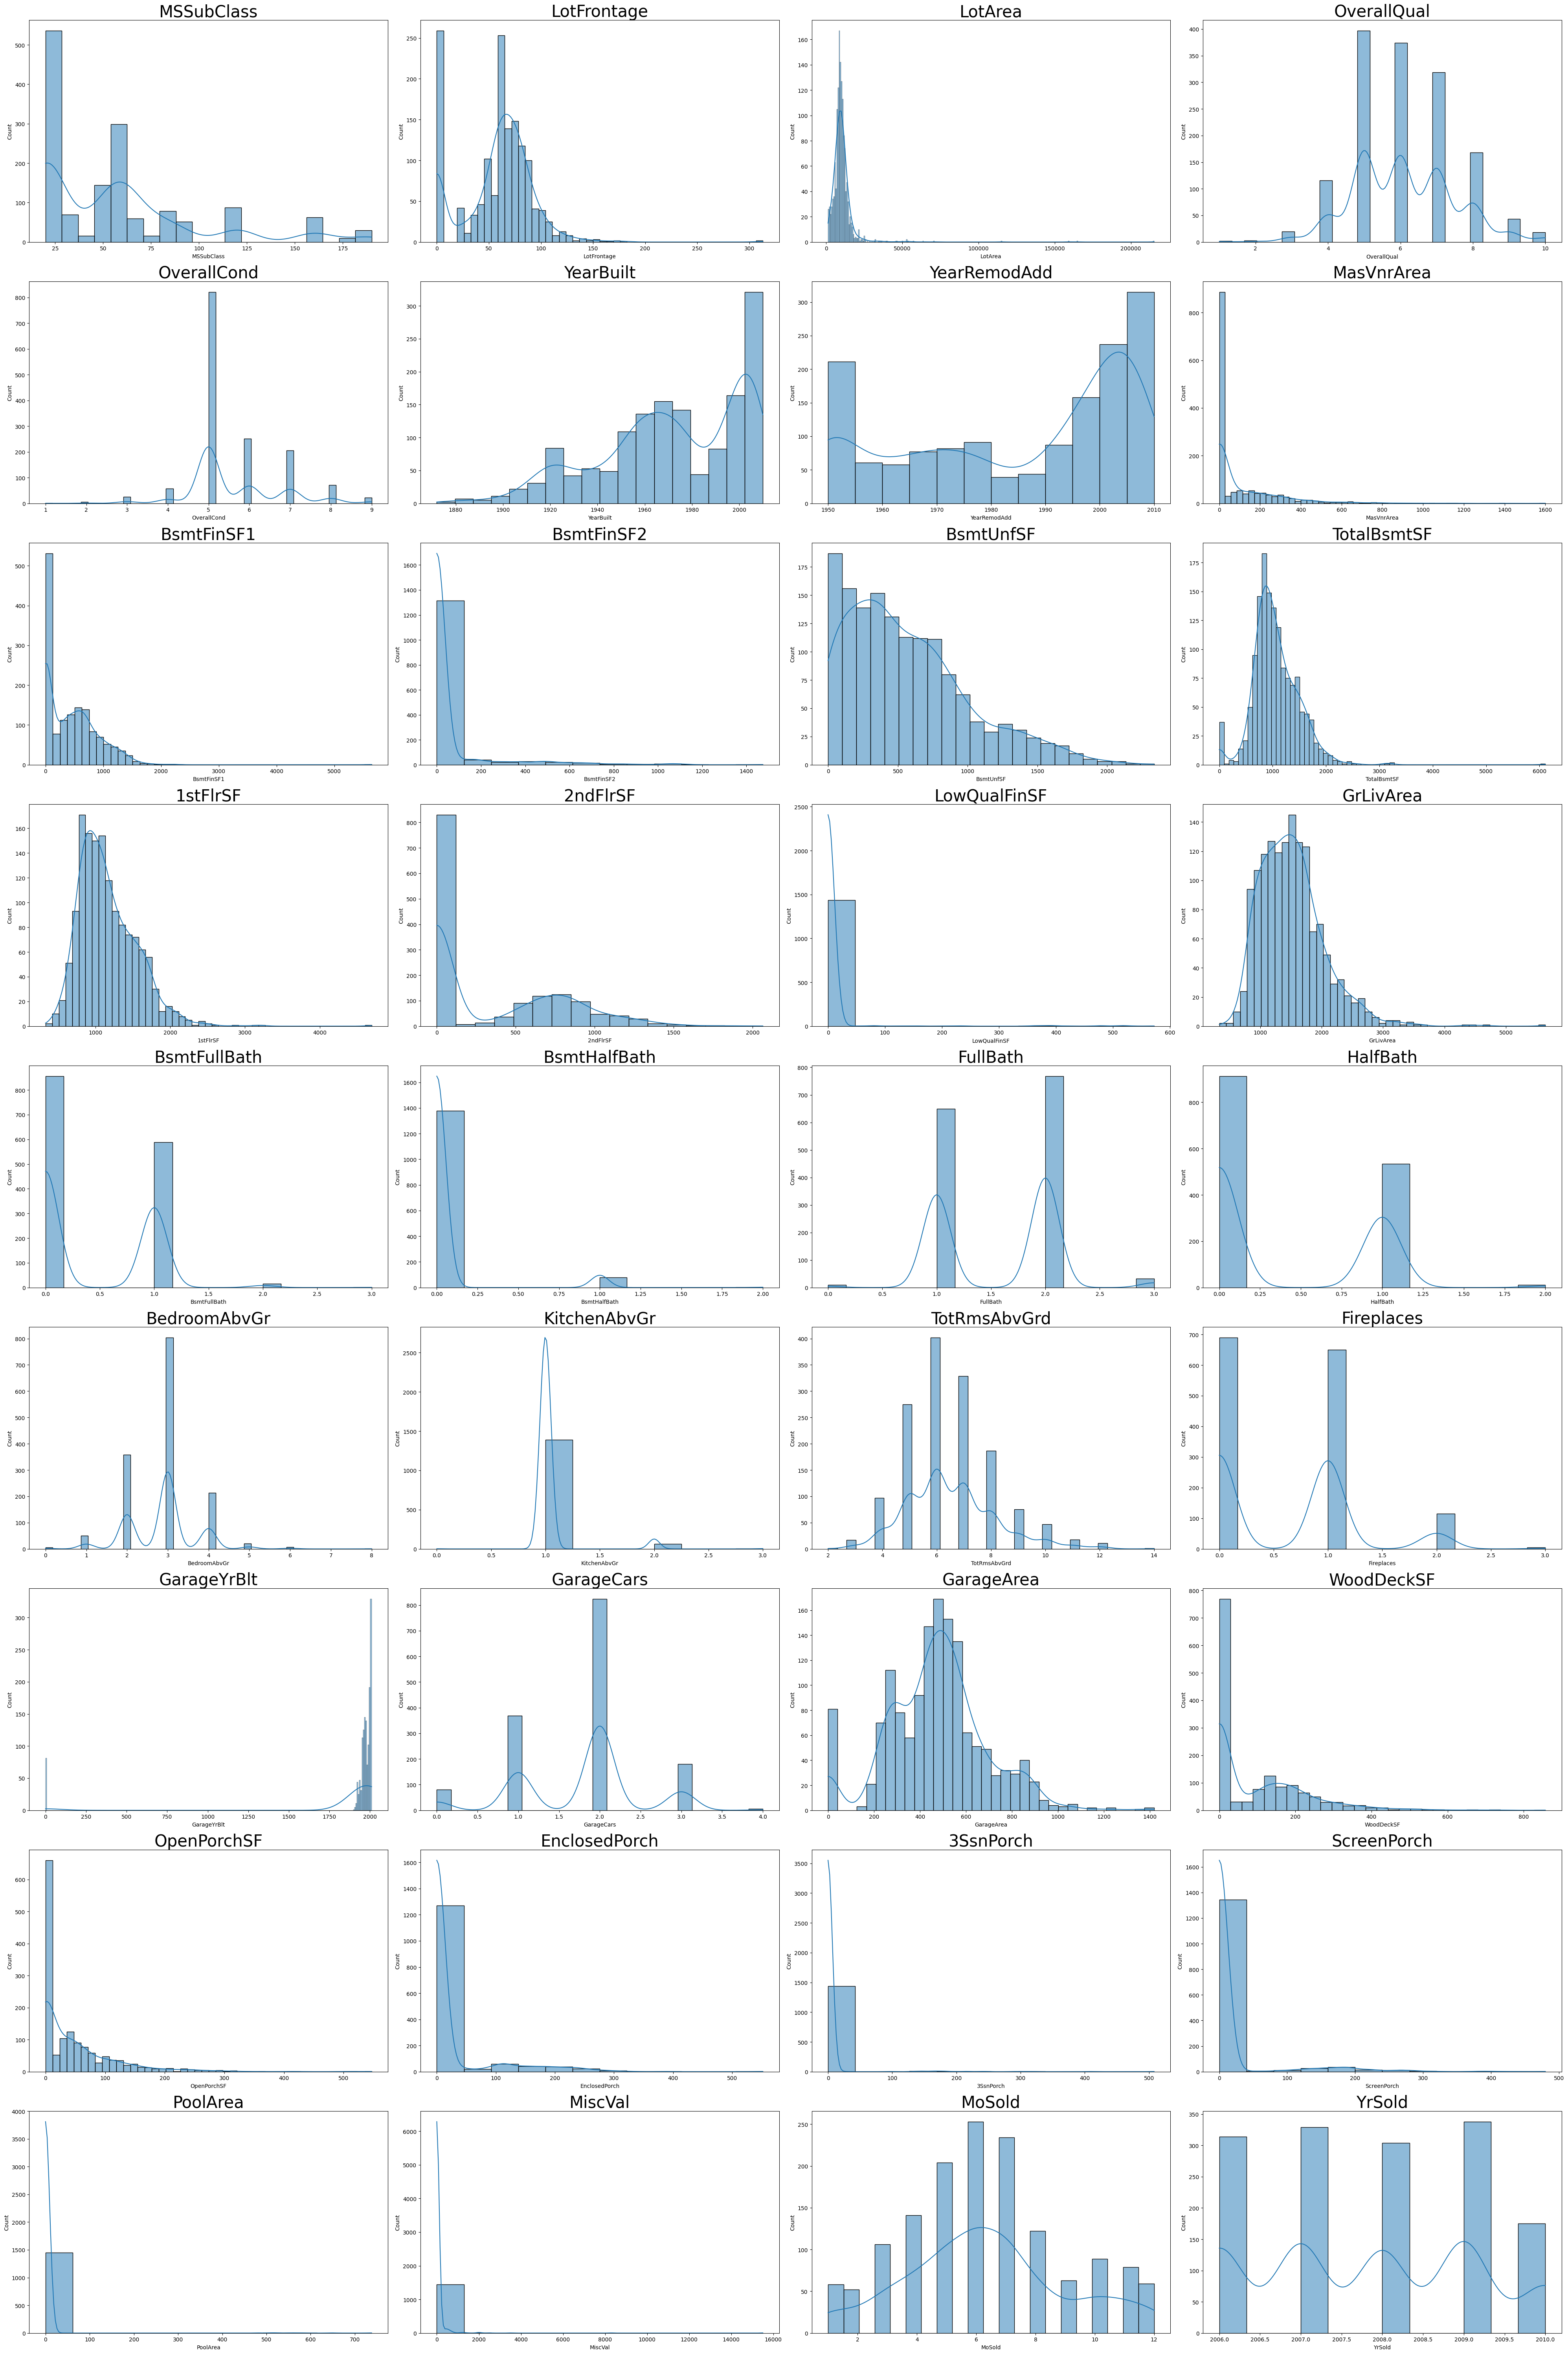

In [20]:
plt.figure(figsize = (40,60))

for i in range(len(num_cols)):
    plt.subplot(9, 4, i + 1) 
    sns.histplot(data= df,x = df[num_cols[i]],kde=True)
    plt.title(num_cols[i],fontsize=30)


    plt.tight_layout()

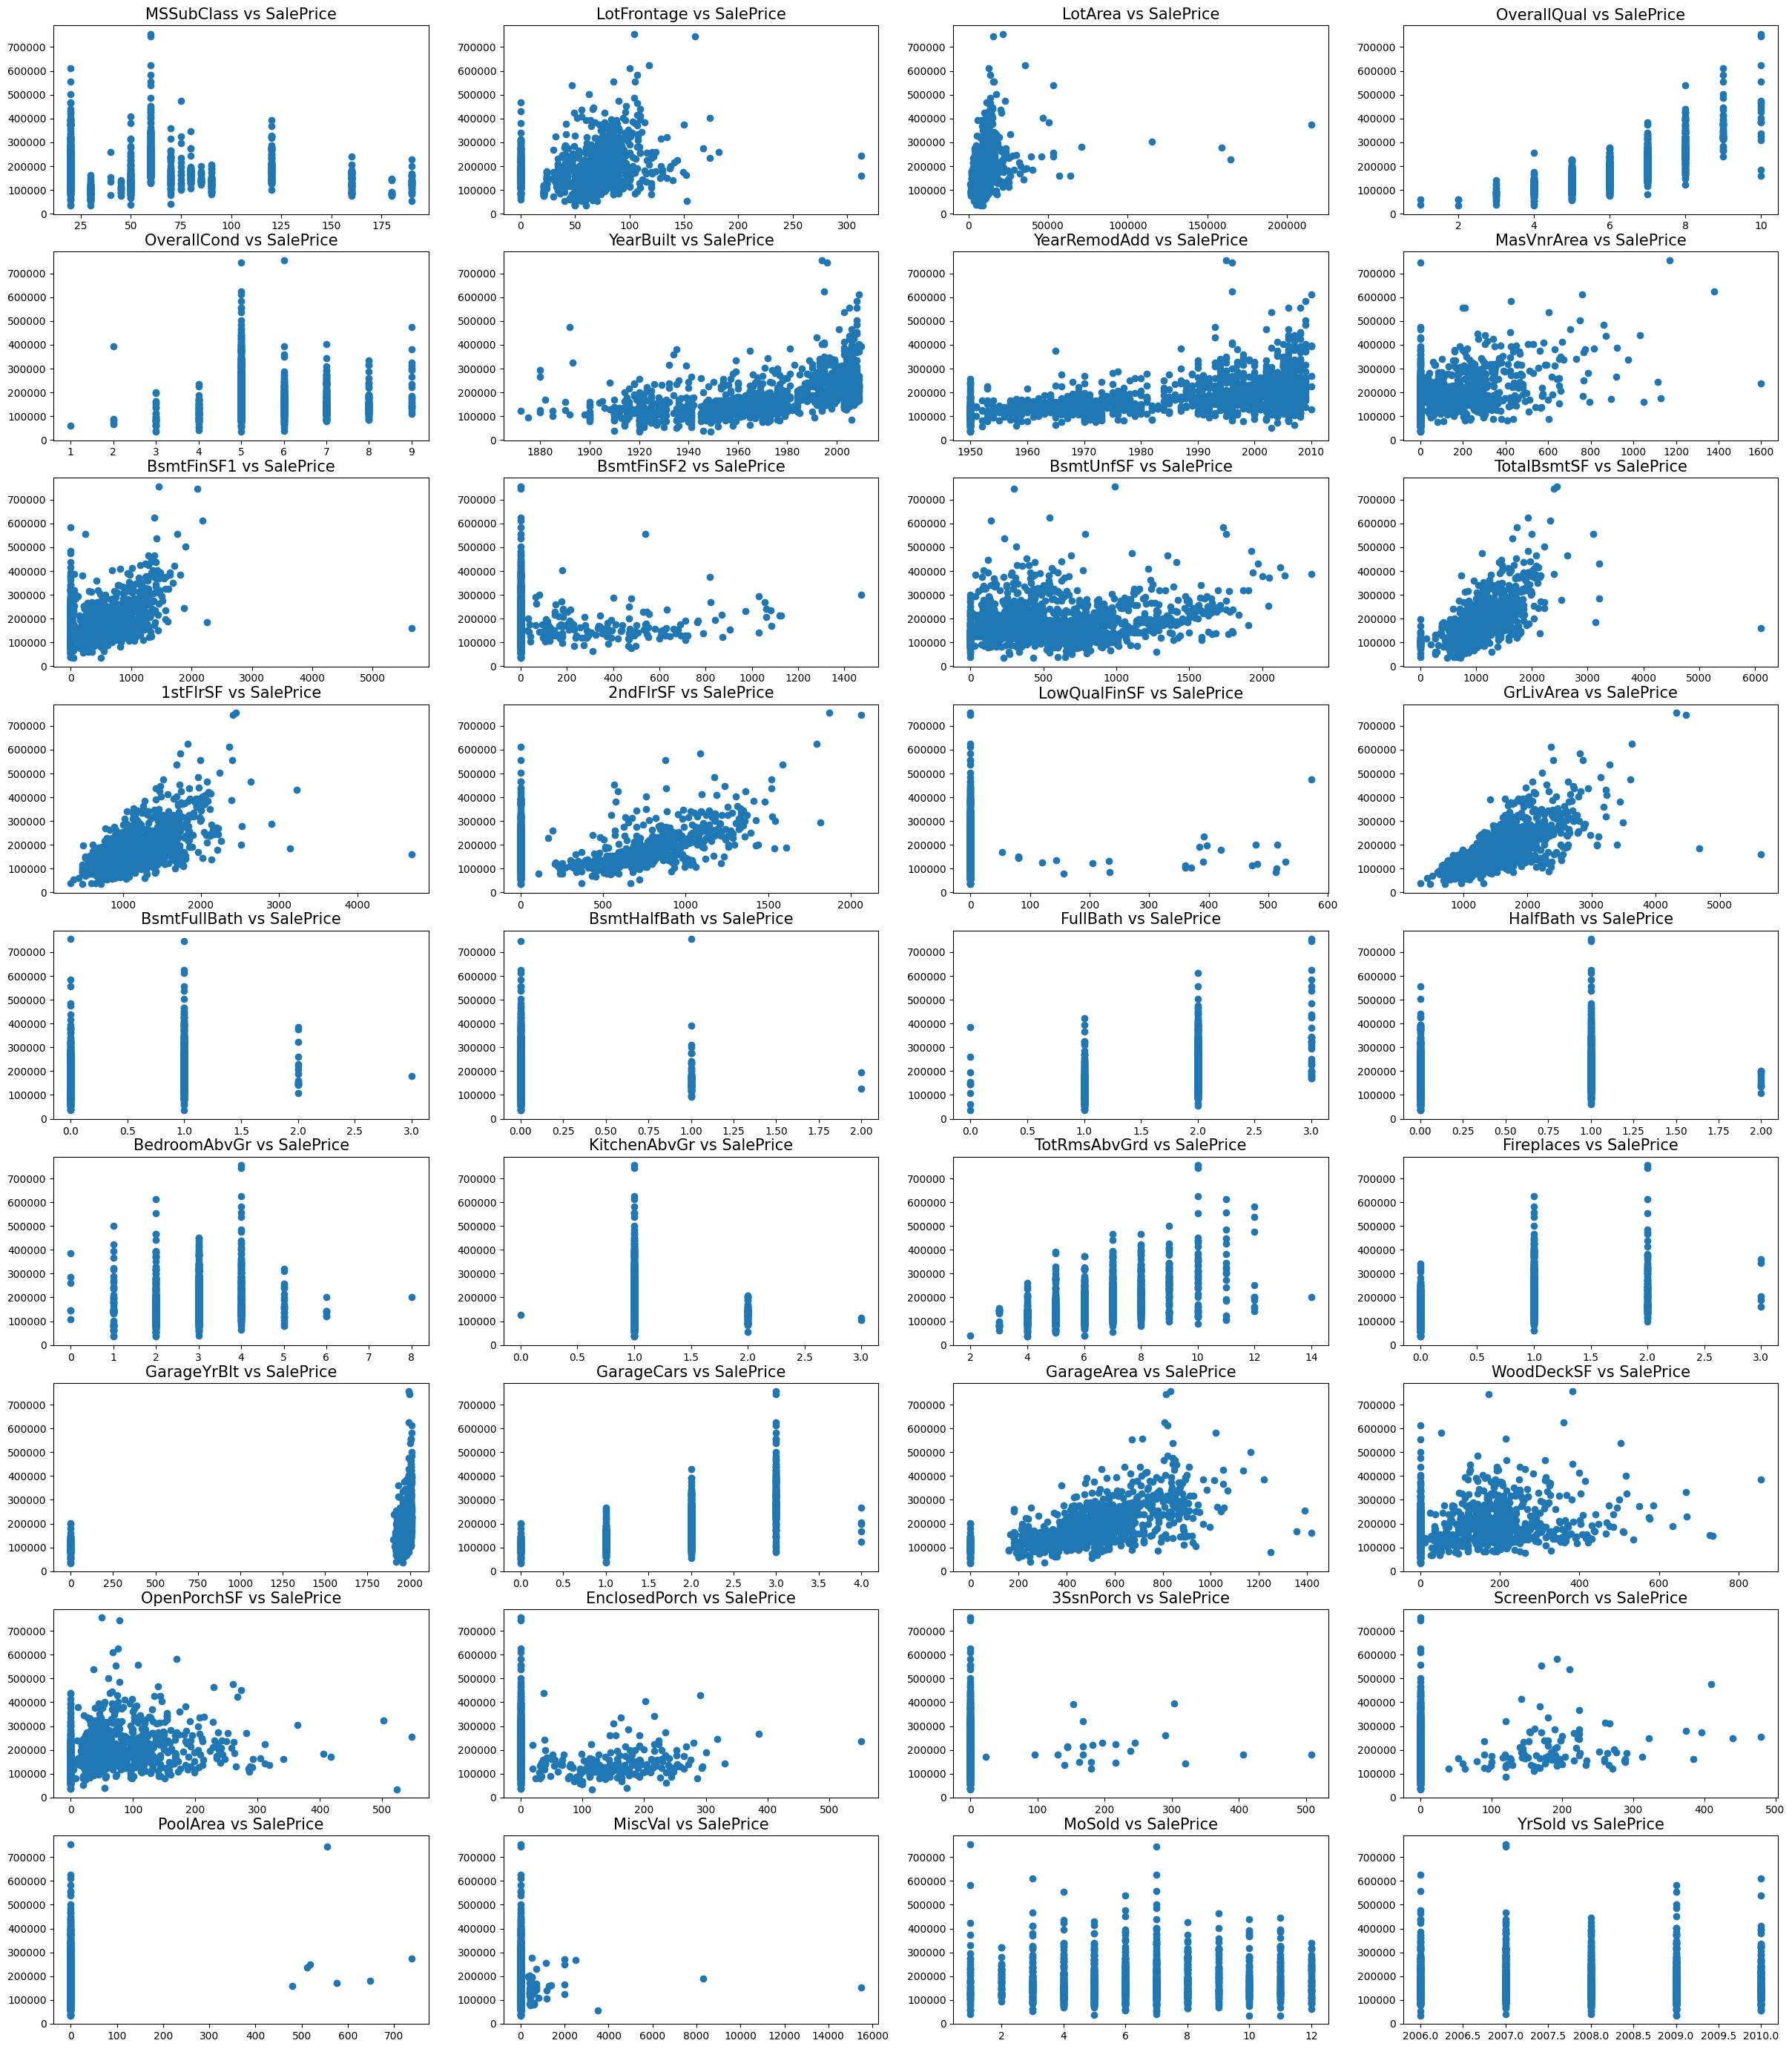

In [21]:
plt.figure(figsize=(30,35))
for i,col in enumerate(num_cols):
    if(col!='SalePrice'):
        plt.subplot(9,4,(i+1))
        plt.scatter(df[col], df['SalePrice'])
        plt.title(col + ' vs SalePrice' ,fontsize=15)

In [22]:
for i in df[cat_cols]:
    print(i)
    print(df[i].value_counts())
    print('###########################################################')

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
###########################################################
Street
Pave    1454
Grvl       6
Name: Street, dtype: int64
###########################################################
Alley
nan     1369
Grvl      50
Pave      41
Name: Alley, dtype: int64
###########################################################
LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
###########################################################
LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
###########################################################
Utilities
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
###########################################################
LotConfig
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
###########################

In [23]:
for i in df[num_cols]:
    print(i)
    print(df[i].value_counts())
    print('###########################################################')

MSSubClass
20.0     536
60.0     299
50.0     144
120.0     87
30.0      69
160.0     63
70.0      60
80.0      58
90.0      52
190.0     30
85.0      20
75.0      16
45.0      12
180.0     10
40.0       4
Name: MSSubClass, dtype: int64
###########################################################
LotFrontage
0.0      259
60.0     143
70.0      70
80.0      69
50.0      57
        ... 
137.0      1
38.0       1
33.0       1
150.0      1
46.0       1
Name: LotFrontage, Length: 111, dtype: int64
###########################################################
LotArea
7200.0     25
9600.0     24
6000.0     17
9000.0     14
8400.0     14
           ..
14601.0     1
13682.0     1
4058.0      1
17104.0     1
9717.0      1
Name: LotArea, Length: 1073, dtype: int64
###########################################################
OverallQual
5.0     397
6.0     374
7.0     319
8.0     168
4.0     116
9.0      43
3.0      20
10.0     18
2.0       3
1.0       2
Name: OverallQual, dtype: int64
###############

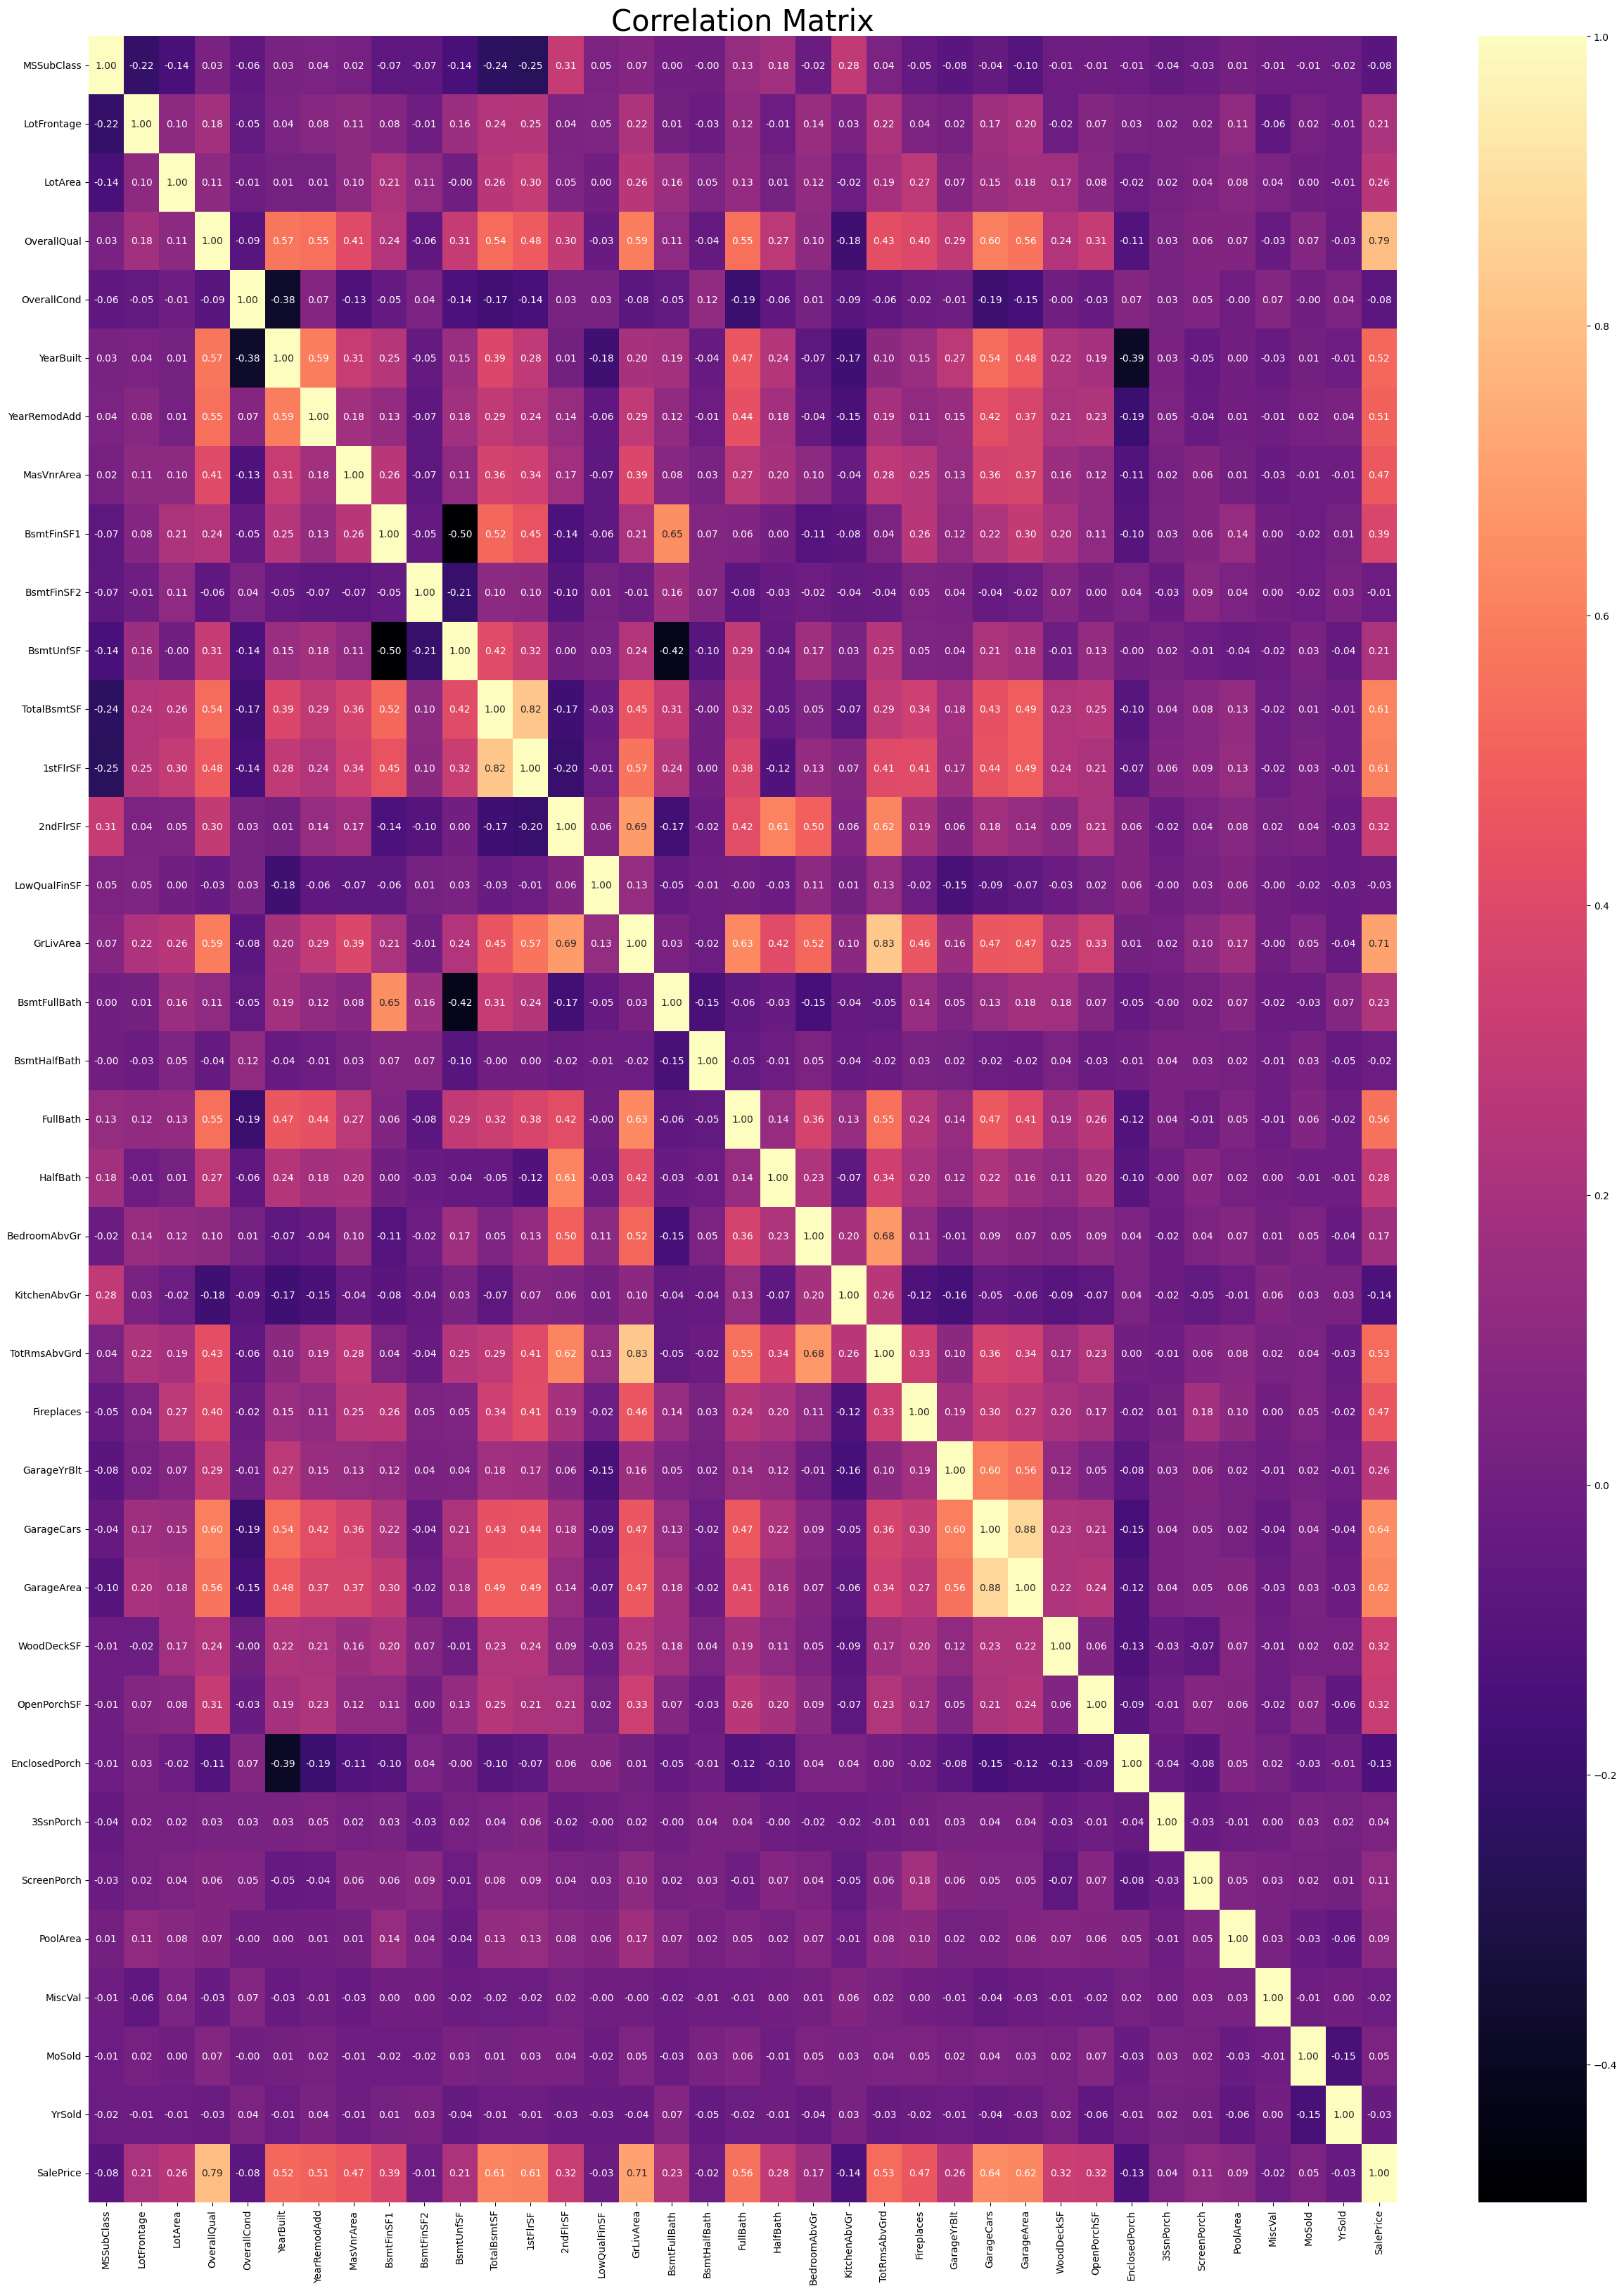

In [24]:
f, ax = plt.subplots(figsize=[30, 40])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=30)
plt.show()

In [25]:
#  Избегаем мультиколлинеарности
# ################################
corr_matrix = df.iloc[:, df.columns!='SalePrice'].corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones_like(corr_matrix, dtype=bool), k=1))
drop_columns = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.7)]
print(f'delete features: {drop_columns}')

for i in drop_columns:
    features.remove(i)
    if i in cat_cols:
        cat_cols.remove(i)
    if i in num_cols:
        num_cols.remove(i)
df.drop(columns=drop_columns,axis=1, inplace=True)
test.drop(columns=drop_columns,axis=1, inplace=True)
df.head()


delete features: ['1stFlrSF', 'TotRmsAbvGrd', 'GarageArea']


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60.0,RL,65.0,8450.0,Pave,nan,Reg,Lvl,AllPub,Inside,...,0.0,nan,nan,nan,0.0,2.0,2008.0,WD,Normal,208500.0
1,20.0,RL,80.0,9600.0,Pave,nan,Reg,Lvl,AllPub,FR2,...,0.0,nan,nan,nan,0.0,5.0,2007.0,WD,Normal,181500.0
2,60.0,RL,68.0,11250.0,Pave,nan,IR1,Lvl,AllPub,Inside,...,0.0,nan,nan,nan,0.0,9.0,2008.0,WD,Normal,223500.0
3,70.0,RL,60.0,9550.0,Pave,nan,IR1,Lvl,AllPub,Corner,...,0.0,nan,nan,nan,0.0,2.0,2006.0,WD,Abnorml,140000.0
4,60.0,RL,84.0,14260.0,Pave,nan,IR1,Lvl,AllPub,FR2,...,0.0,nan,nan,nan,0.0,12.0,2008.0,WD,Normal,250000.0


In [26]:
# Удаляем столбцы с пропущенными значениями (более чем половина длины датафрейма)
d = [df[i].value_counts() for i in list(df[cat_cols].columns)]
for i,j in enumerate(df[cat_cols]):
    if 'nan' in d[i].keys():
        for ind_nan , value_nan, in enumerate(d[i].keys()):
            if value_nan =='nan':
#                 print(value_nan, ind_nan)
                if len(df)/2 <d[i].values[ind_nan]:
                    print(d[i].values[ind_nan])
                    print(j)
                    features.remove(j)
                    cat_cols.remove(j)
                    df = df.drop(j ,axis=1)
                    test = test.drop(j ,axis=1)

1369
Alley
1453
PoolQC
1179
Fence
1406
MiscFeature


In [27]:
# Удаляем столбцы  наименьшей корреляцией к таргету
for i in num_cols:

    if abs(df['SalePrice'].corr(df[i]))<0.1:
        features.remove(i)
        num_cols.remove(i)
        print(f'Удален :{i}')
        df = df.drop(i ,axis=1)
        test = test.drop(i ,axis=1)

Удален :MSSubClass
Удален :OverallCond
Удален :BsmtFinSF2
Удален :LowQualFinSF
Удален :BsmtHalfBath
Удален :3SsnPorch
Удален :PoolArea
Удален :MoSold


In [28]:
# делим на обучающий и тестовый датасеты
# df_train, df_test=train_test_split(df, test_size=0.2)
# df_train
X_train, X_test, y_train, y_test=train_test_split(df[features],df[target], test_size=0.2)

In [29]:
from sklearn import preprocessing

X = X_train #df_train[features]
y = y_train#df_train[target]
# определяем предобработку данных - векторизация для категориальных, scaling для числовых
column_trans = make_column_transformer( (OneHotEncoder(handle_unknown='ignore'), cat_cols),
                                        (StandardScaler(), num_cols),
                                            remainder='passthrough')

In [30]:
#Инициализируем моделей и сетки гиперпараметров
models = []

# XGBOOSTING REGRESSOR
xgb=XGBRegressor()
xgb_grid = {
    'xgbregressor__max_depth':[None, 2, 10, 1,3,4,5],  # [None, 2]
    'xgbregressor__n_estimators':[None,300,400,500,600,800],  # [None,300],
    'xgbregressor__learning_rate':[0.1, 0.01, 0.05]  # [0.1, 0.01]#
}

models.append({
    'name': 'xgb',
    'parent': xgb,
    'grid' : xgb_grid 
})
#---------------------------

# RANDOM FOREST REGRESSOR
rf=RandomForestRegressor()
rf_grid = {
    'randomforestregressor__max_depth':[None, 2, 3, 4, 5, 6],  # [None, 2,],
    'randomforestregressor__n_estimators':[None, 10, 20, 50, 100, 200, 300, 400]  # [None, 200]
}

models.append({
    'name': 'rf',
    'parent': rf,
    'grid' : rf_grid 
})
# #---------------------------

mlp = MLPRegressor()
mlp_grid = {
    'mlpregressor__hidden_layer_sizes':[(64, 128), (128, 256), (64, 128, 256), (64, 256, 64)],
    'mlpregressor__activation': ['relu', 'sigmoid']
}

models.append({
    'name': 'mlp',
    'parent': mlp,
    'grid' : mlp_grid 
})

In [31]:
# Обучение
for model in models:
    m_name = model['name']
    print(f"Training {m_name}...")
    pipeline = make_pipeline(column_trans, model['parent'])

    #Оптимизатор
    gs = GridSearchCV(estimator=pipeline,  
                    param_grid = model['grid'],
                     scoring=None,
                     cv=4,
                     refit=True,
                    )
    # обучение
    gs = gs.fit(X,y)
  #   print(gs.best_score_)
  #   Y_pred = gs.predict(X_test)
  #   print('R2 score: ', r2_score(y_test, Y_pred))
    print("Train r-squared:", gs.score(X_train,y_train))
    print("Test r-squared:", gs.score(X_test, y_test))
    print(f"Best Parameters: {gs.best_params_}")
    print(f"best score: {gs.best_score_}")
    print("-"*20)

    y_pred = gs.predict(test[features])
    output = pd.DataFrame({'Id':test['Id'], 
                              'SalePrice': y_pred})
    output.to_csv(f'submission_catboost_{m_name}.csv', index=False)

Training xgb...
Train r-squared: 0.9933445282481105
Test r-squared: 0.9324034916583499
Best Parameters: {'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 600}
best score: 0.8767048617186252
--------------------
Training rf...
Train r-squared: 0.9790735027407472
Test r-squared: 0.9103133721210829
Best Parameters: {'randomforestregressor__max_depth': None, 'randomforestregressor__n_estimators': 50}
best score: 0.8479430767786728
--------------------
Training mlp...
Train r-squared: 0.8736608069317876
Test r-squared: 0.910283223555714
Best Parameters: {'mlpregressor__activation': 'relu', 'mlpregressor__hidden_layer_sizes': (64, 128, 256)}
best score: 0.8118637263361353
--------------------


In [32]:
cat_model = cb.CatBoostRegressor(loss_function='RMSE', 
                                       random_seed=2, 
                                       max_depth = 10,
                                       learning_rate = 0.05,
                                       random_strength=4,
                                       max_ctr_complexity=1,
                                       l2_leaf_reg=7,
                                       grow_policy = 'Lossguide',
                                      
                                      )
pool_train = cb.Pool(X,y,cat_features=cat_cols)
cat_model.fit(pool_train)

0:	learn: 78562.8515921	total: 56.6ms	remaining: 56.6s
1:	learn: 76776.9255332	total: 63.5ms	remaining: 31.7s
2:	learn: 75095.2943252	total: 69ms	remaining: 22.9s
3:	learn: 73382.3058315	total: 75.1ms	remaining: 18.7s
4:	learn: 71522.0317776	total: 81.2ms	remaining: 16.2s
5:	learn: 69773.3442658	total: 88.2ms	remaining: 14.6s
6:	learn: 68502.9058970	total: 94.8ms	remaining: 13.4s
7:	learn: 66916.3345869	total: 102ms	remaining: 12.7s
8:	learn: 65500.4860193	total: 109ms	remaining: 12s
9:	learn: 64488.9928708	total: 116ms	remaining: 11.5s
10:	learn: 63309.6567461	total: 123ms	remaining: 11.1s
11:	learn: 62047.2069166	total: 130ms	remaining: 10.7s
12:	learn: 60818.9059732	total: 136ms	remaining: 10.3s
13:	learn: 59594.7822027	total: 142ms	remaining: 10s
14:	learn: 58463.7357922	total: 150ms	remaining: 9.87s
15:	learn: 57464.9538038	total: 157ms	remaining: 9.66s
16:	learn: 56622.7761795	total: 164ms	remaining: 9.47s
17:	learn: 55745.1620235	total: 171ms	remaining: 9.33s
18:	learn: 54728.06

165:	learn: 23095.0117805	total: 1.26s	remaining: 6.35s
166:	learn: 22975.9892537	total: 1.27s	remaining: 6.35s
167:	learn: 22884.6873142	total: 1.28s	remaining: 6.35s
168:	learn: 22779.7024054	total: 1.29s	remaining: 6.34s
169:	learn: 22682.3259647	total: 1.3s	remaining: 6.33s
170:	learn: 22567.3230725	total: 1.31s	remaining: 6.33s
171:	learn: 22474.1892998	total: 1.31s	remaining: 6.33s
172:	learn: 22402.3583811	total: 1.32s	remaining: 6.32s
173:	learn: 22312.8046556	total: 1.33s	remaining: 6.32s
174:	learn: 22214.1988943	total: 1.34s	remaining: 6.31s
175:	learn: 22109.6293839	total: 1.35s	remaining: 6.31s
176:	learn: 21990.8189085	total: 1.35s	remaining: 6.3s
177:	learn: 21935.3289475	total: 1.36s	remaining: 6.29s
178:	learn: 21848.8820201	total: 1.37s	remaining: 6.29s
179:	learn: 21759.3648664	total: 1.38s	remaining: 6.28s
180:	learn: 21641.7531001	total: 1.39s	remaining: 6.28s
181:	learn: 21546.6582939	total: 1.4s	remaining: 6.27s
182:	learn: 21459.0370556	total: 1.4s	remaining: 6.

312:	learn: 15346.1171137	total: 2.48s	remaining: 5.45s
313:	learn: 15334.1174275	total: 2.49s	remaining: 5.45s
314:	learn: 15322.8901014	total: 2.5s	remaining: 5.44s
315:	learn: 15315.4002810	total: 2.51s	remaining: 5.43s
316:	learn: 15275.9692771	total: 2.52s	remaining: 5.42s
317:	learn: 15252.6876890	total: 2.52s	remaining: 5.41s
318:	learn: 15225.4873766	total: 2.53s	remaining: 5.4s
319:	learn: 15160.1954321	total: 2.54s	remaining: 5.4s
320:	learn: 15137.6043445	total: 2.55s	remaining: 5.39s
321:	learn: 15093.1930405	total: 2.55s	remaining: 5.38s
322:	learn: 15057.2157320	total: 2.56s	remaining: 5.37s
323:	learn: 15040.1292750	total: 2.57s	remaining: 5.37s
324:	learn: 15030.4860588	total: 2.58s	remaining: 5.36s
325:	learn: 15008.5336222	total: 2.59s	remaining: 5.35s
326:	learn: 14983.0137675	total: 2.6s	remaining: 5.34s
327:	learn: 14965.8432075	total: 2.6s	remaining: 5.34s
328:	learn: 14954.6826707	total: 2.61s	remaining: 5.33s
329:	learn: 14903.9480052	total: 2.62s	remaining: 5.3

465:	learn: 12171.0533954	total: 3.85s	remaining: 4.43s
466:	learn: 12134.8301405	total: 3.86s	remaining: 4.42s
467:	learn: 12131.0552541	total: 3.87s	remaining: 4.41s
468:	learn: 12108.4030004	total: 3.88s	remaining: 4.41s
469:	learn: 12100.7823541	total: 3.88s	remaining: 4.4s
470:	learn: 12094.8636048	total: 3.89s	remaining: 4.39s
471:	learn: 12068.9006091	total: 3.9s	remaining: 4.38s
472:	learn: 12062.9226427	total: 3.91s	remaining: 4.37s
473:	learn: 12050.3260468	total: 3.92s	remaining: 4.37s
474:	learn: 12036.2742568	total: 3.92s	remaining: 4.36s
475:	learn: 12017.6481765	total: 3.93s	remaining: 4.35s
476:	learn: 11988.3042306	total: 3.94s	remaining: 4.34s
477:	learn: 11952.6032858	total: 3.95s	remaining: 4.33s
478:	learn: 11937.8632091	total: 3.96s	remaining: 4.32s
479:	learn: 11916.7812919	total: 3.96s	remaining: 4.31s
480:	learn: 11888.6707521	total: 3.97s	remaining: 4.3s
481:	learn: 11872.4956025	total: 3.98s	remaining: 4.29s
482:	learn: 11864.2892554	total: 3.98s	remaining: 4

618:	learn: 9912.2379497	total: 5.23s	remaining: 3.23s
619:	learn: 9909.0346459	total: 5.24s	remaining: 3.22s
620:	learn: 9901.9963498	total: 5.24s	remaining: 3.21s
621:	learn: 9886.4247850	total: 5.25s	remaining: 3.2s
622:	learn: 9873.0868438	total: 5.26s	remaining: 3.19s
623:	learn: 9864.3471604	total: 5.27s	remaining: 3.18s
624:	learn: 9864.0654299	total: 5.27s	remaining: 3.17s
625:	learn: 9853.9268184	total: 5.28s	remaining: 3.17s
626:	learn: 9852.5770445	total: 5.29s	remaining: 3.16s
627:	learn: 9841.9828638	total: 5.3s	remaining: 3.15s
628:	learn: 9826.8726286	total: 5.3s	remaining: 3.14s
629:	learn: 9820.3164573	total: 5.31s	remaining: 3.13s
630:	learn: 9809.2110261	total: 5.32s	remaining: 3.12s
631:	learn: 9805.1298440	total: 5.33s	remaining: 3.11s
632:	learn: 9800.6566250	total: 5.34s	remaining: 3.1s
633:	learn: 9795.2403639	total: 5.35s	remaining: 3.1s
634:	learn: 9790.8281144	total: 5.36s	remaining: 3.09s
635:	learn: 9789.7730215	total: 5.36s	remaining: 3.08s
636:	learn: 978

769:	learn: 8515.1322612	total: 6.45s	remaining: 1.93s
770:	learn: 8514.4531624	total: 6.46s	remaining: 1.92s
771:	learn: 8502.4134171	total: 6.46s	remaining: 1.91s
772:	learn: 8490.8267103	total: 6.47s	remaining: 1.91s
773:	learn: 8482.0545483	total: 6.48s	remaining: 1.9s
774:	learn: 8466.3640845	total: 6.49s	remaining: 1.89s
775:	learn: 8462.7564357	total: 6.5s	remaining: 1.88s
776:	learn: 8456.3715735	total: 6.51s	remaining: 1.87s
777:	learn: 8446.1494802	total: 6.51s	remaining: 1.86s
778:	learn: 8439.5097069	total: 6.52s	remaining: 1.85s
779:	learn: 8433.1095242	total: 6.53s	remaining: 1.85s
780:	learn: 8420.5098036	total: 6.54s	remaining: 1.84s
781:	learn: 8408.5741706	total: 6.55s	remaining: 1.83s
782:	learn: 8392.4787587	total: 6.55s	remaining: 1.82s
783:	learn: 8376.0245036	total: 6.56s	remaining: 1.81s
784:	learn: 8368.0142298	total: 6.57s	remaining: 1.8s
785:	learn: 8363.8410497	total: 6.58s	remaining: 1.79s
786:	learn: 8359.6658692	total: 6.58s	remaining: 1.79s
787:	learn: 8

922:	learn: 7303.7273334	total: 7.67s	remaining: 642ms
923:	learn: 7300.1054585	total: 7.68s	remaining: 633ms
924:	learn: 7296.1042496	total: 7.69s	remaining: 625ms
925:	learn: 7289.6814662	total: 7.7s	remaining: 617ms
926:	learn: 7280.0884750	total: 7.71s	remaining: 608ms
927:	learn: 7275.2662787	total: 7.72s	remaining: 600ms
928:	learn: 7269.0245085	total: 7.72s	remaining: 592ms
929:	learn: 7256.4530624	total: 7.73s	remaining: 583ms
930:	learn: 7251.1384282	total: 7.74s	remaining: 575ms
931:	learn: 7247.6075920	total: 7.75s	remaining: 567ms
932:	learn: 7237.2081762	total: 7.75s	remaining: 558ms
933:	learn: 7233.1952273	total: 7.76s	remaining: 550ms
934:	learn: 7221.9135097	total: 7.77s	remaining: 542ms
935:	learn: 7216.2060476	total: 7.78s	remaining: 533ms
936:	learn: 7207.9340239	total: 7.79s	remaining: 525ms
937:	learn: 7203.1375569	total: 7.8s	remaining: 516ms
938:	learn: 7195.0813465	total: 7.8s	remaining: 508ms
939:	learn: 7183.5235360	total: 7.81s	remaining: 500ms
940:	learn: 7

In [33]:
print("Train r-squared:",cat_model.score(X_train,y_train))
print("Test r-squared:", cat_model.score(X_test, y_test))
print(f"best score: {cat_model.best_score_}")

Train r-squared: 0.9884119704948727
Test r-squared: 0.9428538877899454
best score: {'learn': {'RMSE': 6773.914448366377}}


In [34]:
y_pred = cat_model.predict(test[features])
output = pd.DataFrame({'Id':test['Id'], 
                          'SalePrice': y_pred})

In [35]:
output.to_csv('submission_catboost.csv', index=False)

In [ ]:
# cat_params = {
#     'l2_leaf_reg' : [7, 8, 9],
#     'random_strength' : [1,2,3,4],
#     'learning_rate' : [0.01, 0.05, 0.005],
#     'max_ctr_complexity': [1, 2, 3],
#     'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']
# }

# cat_model = cb.CatBoostRegressor(loss_function='RMSE', 
#                                        random_seed=2, 
#                                        max_depth = 10,
#                                        learning_rate = 0.05,
#                                        random_strength=1,
#                                        max_ctr_complexity=1,
#                                        l2_leaf_reg=8,
#                                        grow_policy = 'Lossguide',
#                                        task_type='GPU',
#                                       )
# grid_search_results = cat_model.grid_search(cat_params, pool_train, 
#                                             partition_random_seed=2, cv = 5, 
#                                             search_by_train_test_split=True, 
#                                             plot=True)

# grid_search_results['params']


In [ ]:
# grid_search_results